# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, sum, concat, desc, desc, asc, explode, lit, min, max, split, udf, lit, when, lower
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime

In [2]:
# create a Spark session

spark = SparkSession.builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
spark

In [4]:
#for better visibility using jupyter notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json('../data/mini_sparkify_event_data.json')

In [6]:
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.describe().show(1,vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



In [9]:
df.distinct().count()

286500

In [10]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+
only showing top 20 rows



In [23]:
def clean_df(spark, df=df):
    '''
    cleaning database
    : INPUT
    spark - spark session
    df - dataframe
    :OUTPUT
    df- cleaned Dataframe
    '''
    
    #filter empty values in userId
    df=df.filter(df.userId != '')
    
    # create new columns with iso timestamp using ts and registration columns
    df=df.withColumn('event_timestamp', to_timestamp(df['ts']/1000))
    df=df.withColumn('registration_timestamp', to_timestamp(df['registration']/1000))
    
    # create new columns for device and device_os using userAgent column
    df=df.withColumn('device', 
                      when(lower(df.userAgent).contains('windows'), lit('computer'))
                      .when(lower(df.userAgent).contains('macintosh'), lit('computer'))
                      .when(lower(df.userAgent).contains('linux'), lit('computer'))
                      .when(lower(df.userAgent).contains('mobile'), lit('mobile'))
                      .otherwise(lit('other')) )

    df=df.withColumn('device_os', 
                      when(lower(df.userAgent).contains('windows'), lit('windows'))
                      .when(lower(df.userAgent).contains('mac'), lit('mac'))
                      .when(lower(df.userAgent).contains('linux'), lit('linux'))
                      .otherwise(lit('other')) )
    
    #split lacation into seperate city and state columns
    df=df.withColumn('city', split(df['location'],',').getItem(0))
    df=df.withColumn('state', split(df['location'],',').getItem(1))
    
    # create churn_event and downgrade_event columns from page columns
    df=df.withColumn('churn_event', 
                      when(df.page.contains('Cancellation Confirmation'), lit(1))
                      .otherwise(lit(0)) )
    df=df.withColumn('downgrade_event', 
                      when(df.page.contains('Submit Downgrade'), lit(1))
                      .otherwise(lit(0)) )
    
    return df

df=clean_df(spark, df)

In [25]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+--------+---------+--------------------+------+-----+---------+-----------+---------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|    event_timestamp|registration_timestamp|  device|device_os|                city| state|churn|downgrade|churn_event|downgrade_event|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+--------+---------+--------------------+--

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [125]:
df.createOrReplaceTempView("events")
user_table = spark.sql("""
                        SELECT 
                            u.userId as user_id, 
                            u.firstName as first_name, 
                            u.lastName as last_name, 
                            u.gender as gender, 
                            u.city as city,
                            u.state as state,
                            u.device as device,
                            u.device_os as device_os,
                            u.registration_timestamp as registration_timestamp,
                            p.churned as churned,
                            p.downgraded as downgraded,
                            p.session_count as session_count,
                            (p.song_count/p.nextsong_count) as song_ratio,
                            (p.artist_count/p.nextsong_count) as artist_ratio,
                            p.nextsong_count as nextsong_count,
                            (p.likes_count/p.song_count) as likes_ratio,
                            (p.dislike_count/p.song_count) as dislike_ratio,
                            p.error_count as error_count,
                            p.event_count as event_count
                        FROM (SELECT DISTINCT
                                    userId , 
                                    firstName, 
                                    lastName, 
                                    gender, 
                                    location,
                                    city,
                                    state,
                                    userAgent,
                                    device,
                                    device_os ,
                                    registration ,
                                    registration_timestamp 
                                FROM events) AS u
                        JOIN (SELECT DISTINCT
                                    userId, 
                                    MAX(churn_event) as churned,
                                    MAX(downgrade_event) as downgraded,
                                    COUNT(DISTINCT sessionId) as session_count,
                                    COUNT(DISTINCT song) as song_count,
                                    COUNT(DISTINCT artist) as artist_count,
                                    COUNT(CASE WHEN page='NextSong' THEN 1 ELSE NULL END) as nextsong_count,
                                    COUNT(CASE WHEN page=='Thumbs Up' THEN 1 ELSE NULL END) as likes_count,
                                    COUNT(CASE WHEN page=='Thumbs Down' THEN 1 ELSE NULL END) as dislike_count,
                                    COUNT(CASE WHEN page=='Error' THEN 1 ELSE NULL END) as error_count,
                                    COUNT(*) as event_count
                                FROM events GROUP BY userId) AS p
                        ON u.userId=p.userId
                        """)

user_table.show(5)

+-------+----------+---------+------+--------------------+---------+--------+---------+----------------------+-------+----------+-------------+------------------+------------------+--------------+-------------------+--------------------+-----------+-----------+
|user_id|first_name|last_name|gender|                city|    state|  device|device_os|registration_timestamp|churned|downgraded|session_count|        song_ratio|      artist_ratio|nextsong_count|        likes_ratio|       dislike_ratio|error_count|event_count|
+-------+----------+---------+------+--------------------+---------+--------+---------+----------------------+-------+----------+-------------+------------------+------------------+--------------+-------------------+--------------------+-----------+-----------+
| 100010|  Darianna|Carpenter|     F|Bridgeport-Stamfo...|       CT|  mobile|      mac|   2018-09-27 04:45:40|      0|         0|            7|0.9781818181818182|0.9163636363636364|           275|0.0631970260223048

In [47]:
df.createOrReplaceTempView("events")
event_table = spark.sql("""
                    SELECT DISTINCT
                        userId as user_id,
                        sessionId as session_id,
                        itemInSession as item_in_session,
                        page as event,
                        auth,
                        level,
                        ts as event_timestamp_unix,
                        event_timestamp,
                        churn_event,
                        downgrade_event
                    FROM events
                    ORDER BY event_timestamp_unix DESC
                """) 
event_table.show(5)

+-------+----------+---------------+--------+---------+-----+--------------------+-------------------+-----------+---------------+
|user_id|session_id|item_in_session|   event|     auth|level|event_timestamp_unix|    event_timestamp|churn_event|downgrade_event|
+-------+----------+---------------+--------+---------+-----+--------------------+-------------------+-----------+---------------+
| 100002|       198|              0|NextSong|Logged In| paid|       1543799476000|2018-12-03 02:11:16|          0|              0|
| 200008|       408|            133|NextSong|Logged In| paid|       1543622579000|2018-12-01 01:02:59|          0|              0|
|    152|      2409|             37|NextSong|Logged In| paid|       1543622432000|2018-12-01 01:00:32|          0|              0|
| 300011|       500|             45|NextSong|Logged In| paid|       1543622411000|2018-12-01 01:00:11|          0|              0|
| 300011|       500|             44|   About|Logged In| paid|       1543622398000|2

In [134]:
df_user=user_table.toPandas().set_index('user_id')
df_user['churned']=df_user['churned'].map({0:'stayed', 1:'churned'})
df_user['downgraded']=df_user['downgraded'].map({0:'kept level', 1:'downgraded'})
df_user.head()


C:\Users\thoma\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,first_name,last_name,gender,city,state,device,device_os,registration_timestamp,churned,downgraded,session_count,song_ratio,artist_ratio,nextsong_count,likes_ratio,dislike_ratio,error_count,event_count
user_id,,,,,,,,,,,,,,,,,,
100010,Darianna,Carpenter,F,Bridgeport-Stamford-Norwalk,CT,mobile,mac,2018-09-27 04:45:40,stayed,kept level,7,0.978182,0.916364,275,0.063197,0.018587,0,381
200002,Dominic,Torres,M,Chicago-Naperville-Elgin,IL-IN-WI,mobile,mac,2018-09-06 23:38:26,stayed,kept level,6,0.976744,0.875969,387,0.055556,0.015873,0,474
125,Mason,Hart,M,Corpus Christi,TX,computer,mac,2018-08-01 22:58:59,churned,kept level,1,1.000000,1.000000,8,0.000000,0.000000,0,11
51,Ethan,Johnson,M,Lexington-Fayette,KY,computer,windows,2018-09-27 22:43:07,churned,kept level,10,0.878257,0.656087,2111,0.053937,0.011327,1,2464
124,Nicole,Beck,F,Vineland-Bridgeton,NJ,computer,mac,2018-07-22 03:52:15,stayed,kept level,29,0.818583,0.547193,4079,0.051213,0.012279,6,4825


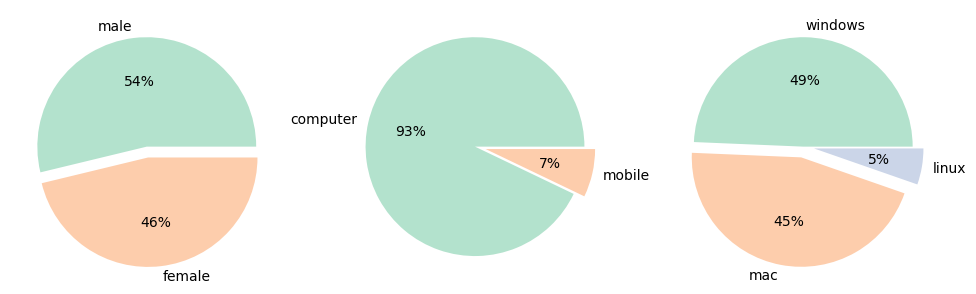

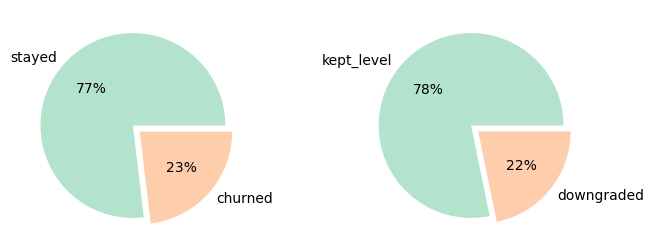

In [16]:
colors=sns.color_palette('Pastel2')

fig, axs = plt.subplots(1, 3, figsize=[12,5])
axs[0].pie(df_user.gender.value_counts(), labels=['male', 'female'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[1].pie(df_user.device.value_counts(), labels=df_user.device.value_counts().index.tolist(),explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[2].pie(df_user.device_os.value_counts(), labels=df_user.device_os.value_counts().index.tolist(),explode=(0,0.1,0.1),autopct='%.0f%%', colors=colors );

fig, axs = plt.subplots(1, 2, figsize=[8,3])
axs[0].pie(df_user.churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[1].pie(df_user.downgraded.value_counts(), labels=[ 'kept_level','downgraded'],explode=(0,0.1),autopct='%.0f%%', colors=colors );


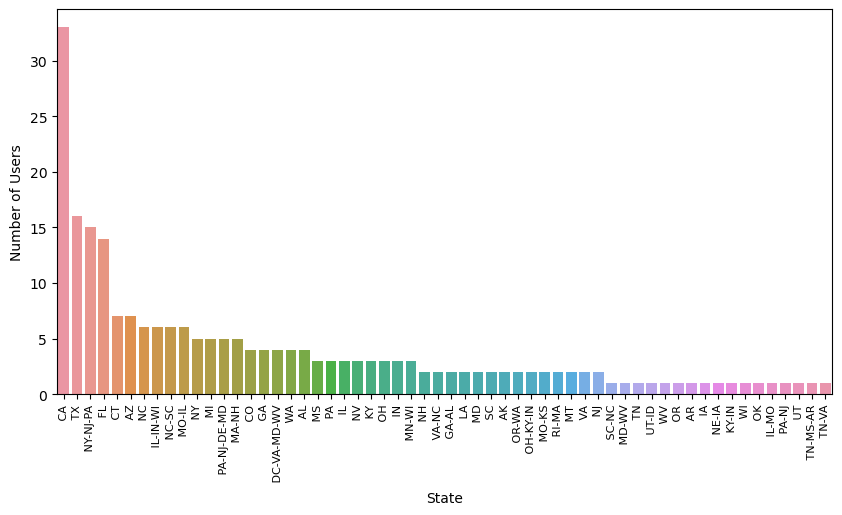

In [17]:
plt.figure( figsize=[10,5])
ax=sns.barplot(x=df_user.state.value_counts().index,y=df_user.state.value_counts(),);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.xlabel('State')
plt.ylabel('Number of Users');

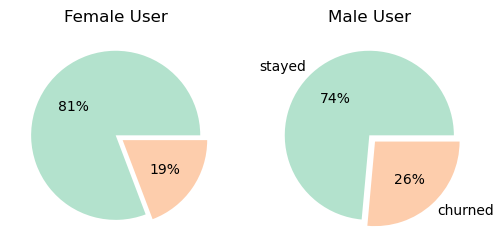

In [136]:
fig, axs = plt.subplots(1, 2, figsize=[6,3])
axs[0].pie(df_user[df_user['gender']=='F'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[0].set_title('Female User')

axs[1].pie(df_user[df_user['gender']=='M'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[1].set_title('Male User');

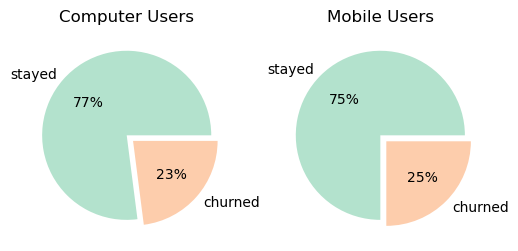

In [19]:
fig, axs = plt.subplots(1, 2, figsize=[6,3])
axs[0].pie(df_user[df_user['device']=='computer'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[0].set_title('Computer Users')

axs[1].pie(df_user[df_user['device']=='mobile'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[1].set_title('Mobile Users');

In [83]:
t=df_user[['churned','likes_ratio', 'dislike_ratio']].groupby(['churned']).mean().unstack().reset_index()
t.columns=['ratio','churned','value']
t

,ratio,churned,value
0,likes_ratio,0,0.059380
1,likes_ratio,1,0.056350
2,dislike_ratio,0,0.011035
3,dislike_ratio,1,0.018285


In [183]:
df_user.head()

,first_name,last_name,gender,city,state,device,device_os,registration_timestamp,churned,downgraded,session_count,song_ratio,artist_ratio,nextsong_count,likes_ratio,dislike_ratio,error_count,event_count
user_id,,,,,,,,,,,,,,,,,,
100010,Darianna,Carpenter,F,Bridgeport-Stamford-Norwalk,CT,mobile,mac,2018-09-27 04:45:40,stayed,kept level,7,0.978182,0.916364,275,0.063197,0.018587,0,381
200002,Dominic,Torres,M,Chicago-Naperville-Elgin,IL-IN-WI,mobile,mac,2018-09-06 23:38:26,stayed,kept level,6,0.976744,0.875969,387,0.055556,0.015873,0,474
125,Mason,Hart,M,Corpus Christi,TX,computer,mac,2018-08-01 22:58:59,churned,kept level,1,1.000000,1.000000,8,0.000000,0.000000,0,11
51,Ethan,Johnson,M,Lexington-Fayette,KY,computer,windows,2018-09-27 22:43:07,churned,kept level,10,0.878257,0.656087,2111,0.053937,0.011327,1,2464
124,Nicole,Beck,F,Vineland-Bridgeton,NJ,computer,mac,2018-07-22 03:52:15,stayed,kept level,29,0.818583,0.547193,4079,0.051213,0.012279,6,4825


In [178]:
def barplot_userfeatures(df,features, hue):
    '''Plot barplot for features'''
    temp=df[[hue]+features].groupby([hue]).mean().unstack().reset_index()
    temp.columns=['features',hue,'value']
    
    ax=sns.catplot(data=temp,x='features',y='value',hue=hue ,kind="bar", palette="Pastel2", height=3, aspect=2 )
    ax.set_axis_labels('','ratio')
    ax.set_xticklabels(list(map(lambda x: x.split('_')[0], features)))
    ax.legend.set_title('');

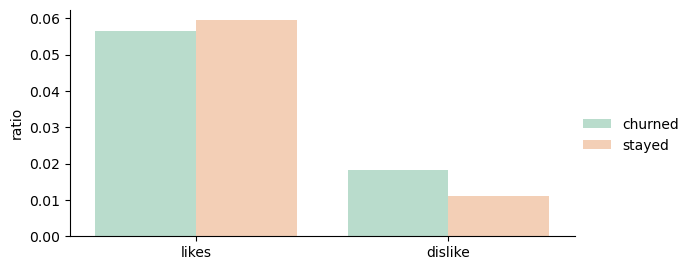

In [179]:
barplot_userfeatures(df=df_user,features=['likes_ratio', 'dislike_ratio'],hue='churned')

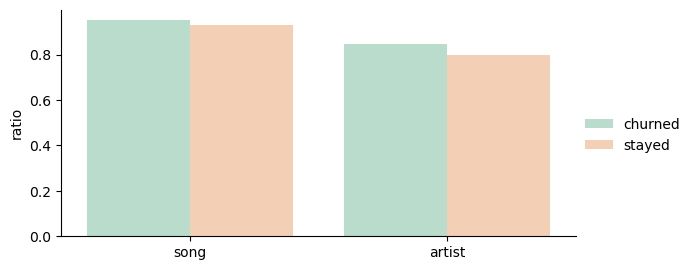

In [180]:
barplot_userfeatures(df=df_user,features=['song_ratio', 'artist_ratio'],hue='churned')

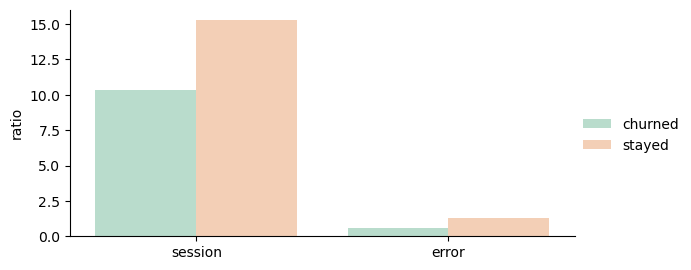

In [184]:
barplot_userfeatures(df=df_user,features=['session_count', 'error_count'],hue='churned')

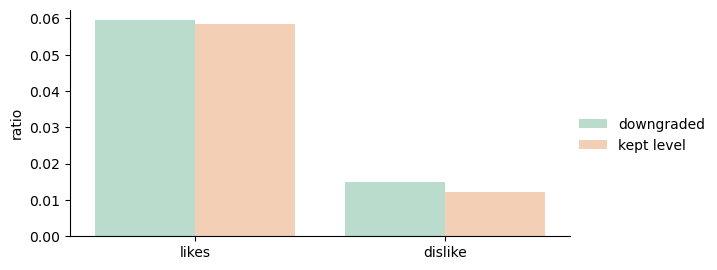

In [181]:
barplot_userfeatures(df=df_user,features=['likes_ratio', 'dislike_ratio'],hue='downgraded')

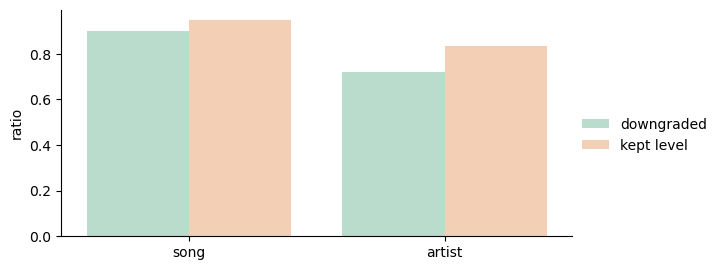

In [182]:
barplot_userfeatures(df=df_user,features=['song_ratio', 'artist_ratio'],hue='downgraded')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [22]:
#spark.stop()